

# Indian start-up ecosystem





Your team is trying to venture into the Indian start-up ecosystem. As the data expert of the team, you are to investigate the ecosystem and propose the best course of action.
Analyze funding received by start-ups in India from 2018 to 2021.
Separate data for each year of funding will be provided.
• In these datasets, you'll find the start-ups' details, the funding amounts received, and the investors' information


# Hypothesis

Null Hypothesis :The location of a sector does not have an impact on the amount of funding

Alternate Hypothesis : The location of a sector has an impact on the amount of funding

Analytical Questions

1. Which Head quarter has the most populated start up location
2. Top 10 headquarters that has the highest start up funding
3. Top 10 sectors that receive the highest start up funding
4. Which year received the highest funding
5. What is the funding trend in the Indian start-up ecosystem over the past few years

STEP 1

Importation of all the needed libraries and dataset

In [ ]:
import pyodbc
from dotenv import dotenv_values
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import f_oneway
import statistics as stat
import warnings
import os

warnings.filterwarnings('ignore')

In [ ]:
# Loading environment variables from .env file into the dictionary
env_variables = dotenv_values('.env')

In [ ]:
# Getting the values for the credentials  set in the '.env' file
server = env_variables.get("SERVER")
database = env_variables.get("DATABASE")
username = env_variables.get("USERNAME")
password = env_variables.get("PASSWORD")

In [ ]:
# code to connect to the server, database, username and passward
connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [ ]:
# conecting to the server
connection = pyodbc.connect(connection_string)

In [ ]:
# importing the 2020 SQL file from the server
query = 'SELECT * FROM LP1_startup_funding2020;'

df_2020= pd.read_sql_query(query, connection)

In [ ]:
# importing the 2021 SQL file from the server
query2 = 'SELECT * FROM LP1_startup_funding2021;'

df_2021 = pd.read_sql_query(query2, connection)

In [ ]:
# Loading the two csv files
df_2018 = pd.read_csv('startup_funding2018.csv')

df_2019 = pd.read_csv('startup_funding2019.csv')

In [ ]:
#Checking the 2018 dataset
df_2018

,Company Name,Industry,Round/Series,Amount,Location,About Company
0,TheCollegeFever,"Brand Marketing, Event Promotion, Marketing, S...",Seed,250000,"Bangalore, Karnataka, India","TheCollegeFever is a hub for fun, fiesta and f..."
1,Happy Cow Dairy,"Agriculture, Farming",Seed,"₹40,000,000","Mumbai, Maharashtra, India",A startup which aggregates milk from dairy far...
2,MyLoanCare,"Credit, Financial Services, Lending, Marketplace",Series A,"₹65,000,000","Gurgaon, Haryana, India",Leading Online Loans Marketplace in India
3,PayMe India,"Financial Services, FinTech",Angel,2000000,"Noida, Uttar Pradesh, India",PayMe India is an innovative FinTech organizat...
4,Eunimart,"E-Commerce Platforms, Retail, SaaS",Seed,—,"Hyderabad, Andhra Pradesh, India",Eunimart is a one stop solution for merchants ...
...,...,...,...,...,...,...
521,Udaan,"B2B, Business Development, Internet, Marketplace",Series C,225000000,"Bangalore, Karnataka, India","Udaan is a B2B trade platform, designed specif..."
522,Happyeasygo Group,"Tourism, Travel",Series A,—,"Haryana, Haryana, India",HappyEasyGo is an online travel domain.
523,Mombay,"Food and Beverage, Food Delivery, Internet",Seed,7500,"Mumbai, Maharashtra, India",Mombay is a unique opportunity for housewives ...
524,Droni Tech,Information Technology,Seed,"₹35,000,000","Mumbai, Maharashtra, India",Droni Tech manufacture UAVs and develop softwa...


In [ ]:
#Checking the 2019 dataset
df_2019

,Company/Brand,Founded,HeadQuarter,Sector,What it does,Founders,Investor,Amount($),Stage
0,Bombay Shaving,NaN,NaN,Ecommerce,Provides a range of male grooming products,Shantanu Deshpande,Sixth Sense Ventures,"$6,300,000",NaN
1,Ruangguru,2014.0,Mumbai,Edtech,A learning platform that provides topic-based ...,"Adamas Belva Syah Devara, Iman Usman.",General Atlantic,"$150,000,000",Series C
2,Eduisfun,NaN,Mumbai,Edtech,It aims to make learning fun via games.,Jatin Solanki,"Deepak Parekh, Amitabh Bachchan, Piyush Pandey","$28,000,000",Fresh funding
3,HomeLane,2014.0,Chennai,Interior design,Provides interior designing solutions,"Srikanth Iyer, Rama Harinath","Evolvence India Fund (EIF), Pidilite Group, FJ...","$30,000,000",Series D
4,Nu Genes,2004.0,Telangana,AgriTech,"It is a seed company engaged in production, pr...",Narayana Reddy Punyala,Innovation in Food and Agriculture (IFA),"$6,000,000",NaN
...,...,...,...,...,...,...,...,...,...
84,Infra.Market,NaN,Mumbai,Infratech,It connects client requirements to their suppl...,"Aaditya Sharda, Souvik Sengupta","Tiger Global, Nexus Venture Partners, Accel Pa...","$20,000,000",Series A
85,Oyo,2013.0,Gurugram,Hospitality,Provides rooms for comfortable stay,Ritesh Agarwal,"MyPreferred Transformation, Avendus Finance, S...","$693,000,000",NaN
86,GoMechanic,2016.0,Delhi,Automobile & Technology,Find automobile repair and maintenance service...,"Amit Bhasin, Kushal Karwa, Nitin Rana, Rishabh...",Sequoia Capital,"$5,000,000",Series B
87,Spinny,2015.0,Delhi,Automobile,Online car retailer,"Niraj Singh, Ramanshu Mahaur, Ganesh Pawar, Mo...","Norwest Venture Partners, General Catalyst, Fu...","$50,000,000",NaN


In [ ]:
#Checking the 2020 dataset
df_2020

,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Amount,Stage,column10
0,Aqgromalin,2019.0,Chennai,AgriTech,Cultivating Ideas for Profit,"Prasanna Manogaran, Bharani C L",Angel investors,200000.0,None,None
1,Krayonnz,2019.0,Bangalore,EdTech,An academy-guardian-scholar centric ecosystem ...,"Saurabh Dixit, Gurudutt Upadhyay",GSF Accelerator,100000.0,Pre-seed,None
2,PadCare Labs,2018.0,Pune,Hygiene management,Converting bio-hazardous waste to harmless waste,Ajinkya Dhariya,Venture Center,NaN,Pre-seed,None
3,NCOME,2020.0,New Delhi,Escrow,Escrow-as-a-service platform,Ritesh Tiwari,"Venture Catalysts, PointOne Capital",400000.0,None,None
4,Gramophone,2016.0,Indore,AgriTech,Gramophone is an AgTech platform enabling acce...,"Ashish Rajan Singh, Harshit Gupta, Nishant Mah...","Siana Capital Management, Info Edge",340000.0,None,None
...,...,...,...,...,...,...,...,...,...,...
1050,Leverage Edu,NaN,Delhi,Edtech,AI enabled marketplace that provides career gu...,Akshay Chaturvedi,"DSG Consumer Partners, Blume Ventures",1500000.0,None,None
1051,EpiFi,NaN,None,Fintech,It offers customers with a single interface fo...,"Sujith Narayanan, Sumit Gwalani","Sequoia India, Ribbit Capital",13200000.0,Seed Round,None
1052,Purplle,2012.0,Mumbai,Cosmetics,Online makeup and beauty products retailer,"Manish Taneja, Rahul Dash",Verlinvest,8000000.0,None,None
1053,Shuttl,2015.0,Delhi,Transport,App based bus aggregator serice,"Amit Singh, Deepanshu Malviya",SIG Global India Fund LLP.,8043000.0,Series C,None


In [ ]:
#Checking the 2021 dataset
df_2021

,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Amount,Stage
0,Unbox Robotics,2019.0,Bangalore,AI startup,Unbox Robotics builds on-demand AI-driven ware...,"Pramod Ghadge, Shahid Memon","BEENEXT, Entrepreneur First","$1,200,000",Pre-series A
1,upGrad,2015.0,Mumbai,EdTech,UpGrad is an online higher education platform.,"Mayank Kumar, Phalgun Kompalli, Ravijot Chugh,...","Unilazer Ventures, IIFL Asset Management","$120,000,000",None
2,Lead School,2012.0,Mumbai,EdTech,LEAD School offers technology based school tra...,"Smita Deorah, Sumeet Mehta","GSV Ventures, Westbridge Capital","$30,000,000",Series D
3,Bizongo,2015.0,Mumbai,B2B E-commerce,Bizongo is a business-to-business online marke...,"Aniket Deb, Ankit Tomar, Sachin Agrawal","CDC Group, IDG Capital","$51,000,000",Series C
4,FypMoney,2021.0,Gurugram,FinTech,"FypMoney is Digital NEO Bank for Teenagers, em...",Kapil Banwari,"Liberatha Kallat, Mukesh Yadav, Dinesh Nagpal","$2,000,000",Seed
...,...,...,...,...,...,...,...,...,...
1204,Gigforce,2019.0,Gurugram,Staffing & Recruiting,A gig/on-demand staffing company.,"Chirag Mittal, Anirudh Syal",Endiya Partners,$3000000,Pre-series A
1205,Vahdam,2015.0,New Delhi,Food & Beverages,VAHDAM is among the world’s first vertically i...,Bala Sarda,IIFL AMC,$20000000,Series D
1206,Leap Finance,2019.0,Bangalore,Financial Services,International education loans for high potenti...,"Arnav Kumar, Vaibhav Singh",Owl Ventures,$55000000,Series C
1207,CollegeDekho,2015.0,Gurugram,EdTech,"Collegedekho.com is Student’s Partner, Friend ...",Ruchir Arora,"Winter Capital, ETS, Man Capital",$26000000,Series B


In [ ]:
#Adding year column to all the data
df_2018['Year']='2018'
df_2019['Year']='2019'
df_2020['Year']='2020'
df_2021['Year']='2021'

STEP 2

Cleaning and concatinating the two CSV files ie 2018 and 2019

In [ ]:


df_2019.drop(['Founded', 'Founders', 'Investor'], axis=1, inplace=True)

In [ ]:
# Selecting specific columns and renaming them
df_2018 = df_2018.rename(columns={'Company Name': 'Company_Brand', 'Round/Series': 'Stage', 'Industry': 'Sector', 'Amount': 'Amount', 'About Company': 'BIO', 'Location':'HeadQuarter'})
df_2019 = df_2019.rename(columns={'Company/Brand': 'Company_Brand', 'Sector': 'Sector', 'Stage': 'Stage', 'Amount($)': 'Amount', 'What it does': 'BIO', 'HeadQuarter':'HeadQuarter'})

# This is done to get a uniform column names for the two datasets

Hamornizing the stage column in 2018 & 2019

Some of the data in the stage column are named differently but  serve the same purpose so it is grouped together and given one common name for easy analysis

In [ ]:
#df_2018
df_2018.replace(to_replace=['Seed round', 'Seed funding', 'Early seed', 'Seed fund', 'Seed Investment', 'Seed Round', 'Seed+'], value='Seed', inplace=True)
df_2018.replace(to_replace=['Angel Round'], value='Angel', inplace=True)
df_2018.replace(to_replace=['Venture - Series Unknown'], value='Undisclosed', inplace=True)
df_2018.replace(to_replace=['Debt Financing', 'Post-IPO Debt'], value='Debt', inplace=True)
df_2018.replace(to_replace=['Private Equity', 'Post-IPO Equity'], value='Equity', inplace=True)
df_2018.replace(to_replace=['Corporate Round', 'Grant', 'Secondary Market', 'Non-equity Assistance', 'Funding Round'], value='Other', inplace=True)
df_2018.replace(to_replace=['Pre-Series B', 'Pre-series B'], value='Pre-Seed', inplace=True)

In [ ]:
#df_2019
df_2019.replace(to_replace=['Seed funding', 'Seed fund', 'Seed round'], value='Seed', inplace=True)
df_2019.replace(to_replace=['Pre series A', 'Pre-series A'], value='Pre-Seed', inplace=True)
df_2019.replace(to_replace=['Series B+'], value='Series B', inplace=True)
df_2019.replace(to_replace=['Post series A', 'Fresh funding'], value='Other', inplace=True)

In [ ]:
# Removing non-standard entries
df_2018 = df_2018[df_2018['Stage'].str.startswith('https') == False]

In [ ]:
df_2018.replace(to_replace=['Bangalore City','Bangalore'], value='Bangalore', inplace=True)
df_2018.replace(to_replace=['Delhi','New Delhi'], value='Delhi', inplace=True)
df_2018.replace(to_replace=['Cochin'], value='Kochi', inplace=True)
df_2018.replace(to_replace=['Kormangala'], value='Koramangala', inplace=True)
df_2018.replace(to_replace=['Powai','Worli'], value='Mumbai', inplace=True)
df_2018.replace(to_replace=['Uttar Pradesh', 'Andhra Pradesh'], value='Andhra Pradesh', inplace=True)
df_2018.replace(to_replace=['Trivandrum', 'India'], value='Trivandrum', inplace=True)

In [ ]:
df_2018.head()

,Company_Brand,Sector,Stage,Amount,HeadQuarter,BIO,Year
0,TheCollegeFever,"Brand Marketing, Event Promotion, Marketing, S...",Seed,250000,"Bangalore, Karnataka, India","TheCollegeFever is a hub for fun, fiesta and f...",2018
1,Happy Cow Dairy,"Agriculture, Farming",Seed,"₹40,000,000","Mumbai, Maharashtra, India",A startup which aggregates milk from dairy far...,2018
2,MyLoanCare,"Credit, Financial Services, Lending, Marketplace",Series A,"₹65,000,000","Gurgaon, Haryana, India",Leading Online Loans Marketplace in India,2018
3,PayMe India,"Financial Services, FinTech",Angel,2000000,"Noida, Uttar Pradesh, India",PayMe India is an innovative FinTech organizat...,2018
4,Eunimart,"E-Commerce Platforms, Retail, SaaS",Seed,—,"Hyderabad, Andhra Pradesh, India",Eunimart is a one stop solution for merchants ...,2018


In [ ]:
df_2019.replace(to_replace=['Delhi' , 'New Delhi'], value='Delhi', inplace=True)

In [ ]:
df_2019['Tech'] = df_2019['Sector'].apply(lambda x: x if 'Tech' in str(x) or 'tech' in str(x) or 'AI' in str(x) or 'IoT' in str(x) else None)
df_2019['Non_tech'] = df_2019['Sector'].apply(lambda x: x if 'Tech' not in str(x) and 'tech' not in str(x)
and 'AI' not in str(x) and 'IoT' not in str(x) else None)

In [ ]:
df_2018['Tech'] = df_2018['Sector'].apply(lambda x: x if 'Tech' in str(x) or 'tech' in str(x) or 'AI' in str(x) or 'IoT' in str(x) else None)
df_2018['Non_tech'] = df_2018['Sector'].apply(lambda x: x if 'Tech' not in str(x) and 'tech' not in str(x)
 and 'AI' not in str(x) and 'IoT' not in str(x) else None)

In [ ]:
df_2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 525 entries, 0 to 525
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Company_Brand  525 non-null    object
 1   Sector         525 non-null    object
 2   Stage          525 non-null    object
 3   Amount         525 non-null    object
 4   HeadQuarter    525 non-null    object
 5   BIO            525 non-null    object
 6   Year           525 non-null    object
 7   Tech           80 non-null     object
 8   Non_tech       445 non-null    object
dtypes: object(9)
memory usage: 41.0+ KB


In [ ]:
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Company_Brand  89 non-null     object
 1   HeadQuarter    70 non-null     object
 2   Sector         84 non-null     object
 3   BIO            89 non-null     object
 4   Amount         89 non-null     object
 5   Stage          43 non-null     object
 6   Year           89 non-null     object
 7   Tech           39 non-null     object
 8   Non_tech       45 non-null     object
dtypes: object(9)
memory usage: 6.4+ KB


In [ ]:
df_2018.duplicated().value_counts()

False    524
True       1
Name: count, dtype: int64

In [ ]:
df_2018.drop_duplicates(keep='first', inplace=True)

In [ ]:
df_2019.duplicated().value_counts()

False    89
Name: count, dtype: int64

In [ ]:
# Merging the 2018 & 2019 csv files 

df_18_19 = pd.concat([df_2018, df_2019], ignore_index=True)

In [ ]:
# Creating a new column 'currency' based on currency symbols

df_18_19['currency'] = df_18_19['Amount'].apply(lambda x: 'INR' if '₹' in x else ('USD' if '$' in x else 'USD'))

In [ ]:
# Create columns 'amount_inr' and 'amount_usd'

df_18_19['amount_inr'] = df_18_19.apply(lambda row: row['Amount'] if row['currency'] == 'INR' else 0, axis=1)
df_18_19['amount_usd'] = df_18_19.apply(lambda row: row['Amount'] if row['currency'] == 'USD' else 0, axis=1)

In [ ]:
# Removing the currency sysmbols and the commas 

df_18_19['amount_inr'] = df_18_19['amount_inr'].str.replace('₹', '').str.replace('$', '').str.replace(',', '')
df_18_19['amount_usd'] = df_18_19['amount_usd'].str.replace('₹', '').str.replace('$', '').str.replace(',', '')

In [ ]:
# Replacing 'Undisclosed' values with NaN

df_18_19['amount_inr'] = df_18_19['amount_inr'].replace('Undisclosed', np.nan, regex=True)
df_18_19['amount_usd'] = df_18_19['amount_usd'].replace('Undisclosed', np.nan, regex=True)

In [ ]:
# Converting the object values into numeric values for calculation

df_18_19['amount_inr'] = pd.to_numeric(df_18_19['amount_inr'], errors='coerce')
df_18_19['amount_usd'] = pd.to_numeric(df_18_19['amount_usd'], errors='coerce')

In [ ]:
# Defining the exchange rate
exchange_rate_inr_to_usd = 1 / 83.23  # 1 USD = 83.23 INR

# Convert 'amount_inr' to USD
df_18_19['amount_inr'] = df_18_19['amount_inr'].apply(lambda x: x * exchange_rate_inr_to_usd if x is not None else None)

In [ ]:
# Create a new column 'Updated_Amount' by filling missing values in 'amount_inr' with 'amount_usd'

df_18_19['Updated_Amount'] = df_18_19['amount_inr'].fillna(df_18_19['amount_usd'])

In [ ]:
df_18_19.duplicated().value_counts()

False    613
Name: count, dtype: int64

STEP 4

Cleaning and Concating the 2 sql file 2020
& 2021

In [ ]:
# Renaming the Column

df_2020 = df_2020.rename(columns={'Company_Brand': 'Company_Brand', 'Sector': 'Sector', 'Amount': 'Amount', 'What_it_does': 'BIO', 'Location':'HeadQuarter'})
df_2021 = df_2021.rename(columns={'Company_Brand': 'Company_Brand', 'Sector': 'Sector', 'Amount': 'Amount', 'What_it_does': 'BIO', 'HeadQuarter':'HeadQuarter'})

Dropping unwanted columns

In [ ]:
df_2020.drop(['Founded', 'Founders', 'Investor'], axis=1, inplace=True)
df_2021.drop(['Founded', 'Founders', 'Investor'], axis=1, inplace=True)
df_2020.drop(columns=['column10'], inplace=True)

# CLEANING THE DATAFRAMES 

<b>Harmonising the Stage column entries in 2020&2021 data.<b>

In [ ]:
# data2020 DataFrame 

df_2020.replace(to_replace=['Seed Round', 'Seed round', 'Seed funding', 'Seed A', 'Seed Funding', 'Seed Investment','Pre seed Round', 'Seed funding' 'Seed A' 'Pre-seed', 'Pre seed round', 'Pre-seed Round', 'Pre-Seed'], value='Seed', inplace=True)
df_2020.replace(to_replace=['Series A1', 'Series A-1'], value='Series A', inplace=True)
df_2020.replace(to_replace=['Series B2'], value='Series B', inplace=True)
df_2020.replace(to_replace=['Pre series B', 'Pre-Series B', 'Pre series C', 'Pre-Series B' 'Pre series C','Pre series A1', 'Pre-series', 'Pre series A', 'Pre-series A', 'Pre- series A', 'Pre Series A', 'Pre-series A1', 'Pre-series C', 'Pre-series B'], value='Pre-Series', inplace=True)
df_2020.replace(to_replace=['Series E', 'Series E2', 'Series F'], value='Series E and Beyond', inplace=True)
df_2020.replace(to_replace=['Series C, D', 'Series D', 'Series D1'], value='Series D', inplace=True)
df_2020.replace(to_replace=['Bridge Round', 'Edge', 'Bridge'], value='Bridge', inplace=True)
df_2020.replace(to_replace=['Angel Round'], value='Angel', inplace=True)

In [ ]:
# data2021 DataFrame

df_2021.replace(to_replace=['Seed Round', 'Seed round', 'Seed funding', 'Seed A', 'Seed+', 'Seed Funding', 'Seed Investment','Pre seed Round', 'Early seed', 'Seed funding' 'Seed A' 'Pre-seed', 'Pre seed round', 'Pre-seed', 'Pre-seed Round', 'Pre-Seed'], value='Seed', inplace=True)
df_2021.replace(to_replace=['Series A1', 'Seies A', 'Series A2', 'Series A+', 'Series A-1'], value='Series A', inplace=True)
df_2021.replace(to_replace=['Series B2', 'Series B3'], value='Series B', inplace=True)
df_2021.replace(to_replace=['Pre series B', 'Pre-Series B', 'Pre series C', 'Pre-Series B' 'Pre series C','Pre series A1', 'Pre-series', 'Pre series A', 'Pre-series A', 'Pre- series A', 'Pre Series A', 'Pre-series A1', 'Pre-series C', 'Pre-series B'], value='Pre-Series', inplace=True)
df_2021.replace(to_replace=['Series E', 'Series I', 'Series F1', 'Series H', 'Series G', 'Series F2', 'Series E2', 'Series F'], value='Series E and Beyond', inplace=True)
df_2021.replace(to_replace=['Series C, D', 'Series D', 'Series D1'], value='Series D', inplace=True)
df_2021.replace(to_replace=['Bridge Round', 'Edge', 'Bridge'], value='Bridge', inplace=True)
df_2021.replace(to_replace=['Angel Round', '$300000', '$1200000', '$6000000', '$1000000'], value='Angel', inplace=True)

<b>Harmonising the Sector column entries in 2020&2021 data.<b>

In [ ]:
# data cleaning of Sector in 2020

df_2020['Tech'] = df_2020['Sector'].apply(lambda x: x if 'Tech' in str(x) or 'tech' in str(x) or 'AI' in str(x) or 'IoT' in str(x) else None)
df_2020['Non_tech'] = df_2020['Sector'].apply(lambda x: x if 'Tech' not in str(x) and 'tech' not in str(x)
 and 'AI' not in str(x) and 'IoT' not in str(x) else None)

In [ ]:
# data cleaning of Sector in 2021

df_2021['Tech'] = df_2021['Sector'].apply(lambda x: x if 'Tech' in str(x) or 'tech' in str(x) or 'AI' in str(x) or 'IoT' in str(x) else None)
df_2021['Non_tech'] = df_2021['Sector'].apply(lambda x: x if 'Tech' not in str(x) and 'tech' not in str(x)
  and 'AI' not in str(x) and 'IoT' not in str(x) else None)

<b>Harmonising the HeadQuarter column entries in 2020&2021 data.<b>

In [ ]:
df_2021.replace(to_replace=['London', 'New York', ' Mountain View', 'CA ', 'Beijing', '' ], value='Outside_India', inplace=True)
df_2021.replace(to_replace=['Online Media\t#REF!', 'Pharmaceuticals\t#REF!', 'Food & Beverages', 
                             'Computer Games', 'Small Towns', ' None', 'None', 'Information Technology & Services'], value='Undisclosed', inplace=True)
df_2021.replace(to_replace=['Gurugram\t#REF!' ], value='Gurugrama', inplace=True)

<b>CHECK FOR DUPLICATE ENTRIES IN THE NEW DATASET df_2020 & df_2021<b>

In [ ]:
df_2020.duplicated().value_counts()

False    1050
True        5
Name: count, dtype: int64

In [ ]:
df_2020.drop_duplicates(keep='first', inplace=True)

In [ ]:
df_2021.duplicated().value_counts()

False    1189
True       20
Name: count, dtype: int64

In [ ]:
df_2021.drop_duplicates(keep='first', inplace=True)

Currency Convertion 

In [ ]:
# Merging the two sql files 

df20_21 = pd.concat([df_2020, df_2021], ignore_index=True)

In [ ]:
df20_21

,Company_Brand,HeadQuarter,Sector,BIO,Amount,Stage,Year,Tech,Non_tech
0,Aqgromalin,Chennai,AgriTech,Cultivating Ideas for Profit,200000.0,None,2020,AgriTech,None
1,Krayonnz,Bangalore,EdTech,An academy-guardian-scholar centric ecosystem ...,100000.0,Pre-seed,2020,EdTech,None
2,PadCare Labs,Pune,Hygiene management,Converting bio-hazardous waste to harmless waste,NaN,Pre-seed,2020,None,Hygiene management
3,NCOME,New Delhi,Escrow,Escrow-as-a-service platform,400000.0,None,2020,None,Escrow
4,Gramophone,Indore,AgriTech,Gramophone is an AgTech platform enabling acce...,340000.0,None,2020,AgriTech,None
...,...,...,...,...,...,...,...,...,...
2234,Gigforce,Gurugram,Staffing & Recruiting,A gig/on-demand staffing company.,$3000000,Pre-Series,2021,None,Staffing & Recruiting
2235,Vahdam,New Delhi,Undisclosed,VAHDAM is among the world’s first vertically i...,$20000000,Series D,2021,None,Undisclosed
2236,Leap Finance,Bangalore,Financial Services,International education loans for high potenti...,$55000000,Series C,2021,None,Financial Services
2237,CollegeDekho,Gurugram,EdTech,"Collegedekho.com is Student’s Partner, Friend ...",$26000000,Series B,2021,EdTech,None


In [ ]:
# Create a new column 'Updated_Amount' by filling missing values in 'amount_inr' with 'amount_usd'

df20_21['Updated_Amount'] = df20_21['Amount']

In [ ]:
# Create a column 'with_$' for values with '$' sign and 'without_$' for values without '$'

df20_21['with_$'] = df20_21['Updated_Amount'].apply(lambda x: x if '$' in str(x) else None)
df20_21['without_$'] = df20_21['Updated_Amount'].apply(lambda x: x if '$' not in str(x) else None)


In [ ]:
# Remove the currency sysmbols and the commas 

df20_21['with_$'] = df20_21['with_$'].str.replace('$', '')


In [ ]:
# Replace 'Undisclosed' values with NaN

df20_21['with_$'] = df20_21['with_$'].replace('Undisclosed', np.nan, regex=True)

In [ ]:
# Convert the object values into numeric values for calculation

df20_21['with_$'] = pd.to_numeric(df20_21['with_$'], errors='coerce')
df20_21['without_$'] = pd.to_numeric(df20_21['without_$'], errors='coerce')

In [ ]:
# Merge the two Colunms into a new colunm 

df20_21['Updated_Amount'] = df20_21['without_$'].fillna(df20_21['with_$'])

In [ ]:
df20_21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2239 entries, 0 to 2238
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Company_Brand   2239 non-null   object 
 1   HeadQuarter     2145 non-null   object 
 2   Sector          2226 non-null   object 
 3   BIO             2239 non-null   object 
 4   Amount          1983 non-null   object 
 5   Stage           1358 non-null   object 
 6   Year            2239 non-null   object 
 7   Tech            895 non-null    object 
 8   Non_tech        1331 non-null   object 
 9   Updated_Amount  1402 non-null   float64
 10  with_$          605 non-null    float64
 11  without_$       797 non-null    float64
dtypes: float64(3), object(9)
memory usage: 210.0+ KB


In [ ]:
df_18_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Company_Brand   613 non-null    object 
 1   Sector          608 non-null    object 
 2   Stage           567 non-null    object 
 3   Amount          613 non-null    object 
 4   HeadQuarter     594 non-null    object 
 5   BIO             613 non-null    object 
 6   Year            613 non-null    object 
 7   Tech            119 non-null    object 
 8   Non_tech        489 non-null    object 
 9   currency        613 non-null    object 
 10  amount_inr      144 non-null    float64
 11  amount_usd      309 non-null    float64
 12  Updated_Amount  453 non-null    float64
dtypes: float64(3), object(10)
memory usage: 62.4+ KB


# Merging All the Files 

In [ ]:
df_18_19.drop(['amount_usd', 'amount_inr', 'currency'], axis=1, inplace=True)
df20_21.drop(['without_$', 'with_$'], axis=1, inplace=True)


In [ ]:
india_startup_df = pd.concat([df_18_19, df20_21], ignore_index=True)

In [ ]:
india_startup_df

,Company_Brand,Sector,Stage,Amount,HeadQuarter,BIO,Year,Tech,Non_tech,Updated_Amount
0,TheCollegeFever,"Brand Marketing, Event Promotion, Marketing, S...",Seed,250000,"Bangalore, Karnataka, India","TheCollegeFever is a hub for fun, fiesta and f...",2018,None,"Brand Marketing, Event Promotion, Marketing, S...",2.500000e+05
1,Happy Cow Dairy,"Agriculture, Farming",Seed,"₹40,000,000","Mumbai, Maharashtra, India",A startup which aggregates milk from dairy far...,2018,None,"Agriculture, Farming",4.805959e+05
2,MyLoanCare,"Credit, Financial Services, Lending, Marketplace",Series A,"₹65,000,000","Gurgaon, Haryana, India",Leading Online Loans Marketplace in India,2018,None,"Credit, Financial Services, Lending, Marketplace",7.809684e+05
3,PayMe India,"Financial Services, FinTech",Angel,2000000,"Noida, Uttar Pradesh, India",PayMe India is an innovative FinTech organizat...,2018,"Financial Services, FinTech",None,2.000000e+06
4,Eunimart,"E-Commerce Platforms, Retail, SaaS",Seed,—,"Hyderabad, Andhra Pradesh, India",Eunimart is a one stop solution for merchants ...,2018,None,"E-Commerce Platforms, Retail, SaaS",NaN
...,...,...,...,...,...,...,...,...,...,...
2847,Gigforce,Staffing & Recruiting,Pre-Series,$3000000,Gurugram,A gig/on-demand staffing company.,2021,None,Staffing & Recruiting,3.000000e+06
2848,Vahdam,Undisclosed,Series D,$20000000,New Delhi,VAHDAM is among the world’s first vertically i...,2021,None,Undisclosed,2.000000e+07
2849,Leap Finance,Financial Services,Series C,$55000000,Bangalore,International education loans for high potenti...,2021,None,Financial Services,5.500000e+07
2850,CollegeDekho,EdTech,Series B,$26000000,Gurugram,"Collegedekho.com is Student’s Partner, Friend ...",2021,EdTech,None,2.600000e+07


In [ ]:

# Fill missing values in the specific column with 0.0
india_startup_df['Updated_Amount'].fillna(0.0, inplace=True)
india_startup_df['Amount'].fillna(0.0, inplace=True)



In [ ]:
# Fill missing values in  with "unknown"
india_startup_df.fillna("NaN", inplace=True)

In [ ]:
india_startup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2852 entries, 0 to 2851
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Company_Brand   2852 non-null   object 
 1   Sector          2852 non-null   object 
 2   Stage           2852 non-null   object 
 3   Amount          2852 non-null   object 
 4   HeadQuarter     2852 non-null   object 
 5   BIO             2852 non-null   object 
 6   Year            2852 non-null   object 
 7   Tech            2852 non-null   object 
 8   Non_tech        2852 non-null   object 
 9   Updated_Amount  2852 non-null   float64
dtypes: float64(1), object(9)
memory usage: 222.9+ KB


In [ ]:
india_startup_df['Stage'].value_counts()

Stage
NaN                      927
Seed                     743
Series A                 308
Pre-Series               303
Series B                 138
Series C                 113
Debt                      60
Series D                  53
Angel                     46
Series E and Beyond       41
Undisclosed               39
Other                     19
Pre-Seed                  15
Equity                    13
Pre-seed                  11
Bridge                    10
Series E                   6
Series H                   2
Series F                   1
Series G                   1
Seed Round & Series A      1
Mid series                 1
PE                         1
Name: count, dtype: int64

In [ ]:
# Calculate the count of missing values in a specific column
missing_values_count = india_startup_df['Updated_Amount'].isna()
missing_values_count


0       False
1       False
2       False
3       False
4       False
        ...  
2847    False
2848    False
2849    False
2850    False
2851    False
Name: Updated_Amount, Length: 2852, dtype: bool

In [ ]:
# Get the Sum

total_funding = india_startup_df.groupby('Tech')['Updated_Amount'].mean()

In [ ]:
india_startup_df['Sector'].value_counts()

Sector
FinTech                                                                              171
EdTech                                                                               141
Fintech                                                                               85
Financial Services                                                                    75
Undisclosed                                                                           73
                                                                                    ... 
Battery, Electric Vehicle, Energy, Renewable Energy, Transportation                    1
Agriculture, Farmers Market, Farming                                                   1
Artificial Intelligence, Drones, Navigation, Packaging Services, Robotics              1
Fitness, GreenTech, Internet of Things, Mobile Apps, Ride Sharing, Transportation      1
Staffing & Recruiting                                                                  1
Name: count, L

# ANALYSIS - ANWERING ANALYTICAL QUESTIONS ON THE DATA

In [ ]:
india_startup_df.describe()

,Updated_Amount
count,2.852000e+03
mean,4.181629e+07
std,1.313663e+09
min,0.000000e+00
25%,0.000000e+00
50%,7.375000e+05
75%,5.279500e+06
max,7.000000e+10



QUESTION 1

 Which Headquarter has the most populated start up location

In [ ]:
most_pop_location = india_startup_df.groupby('HeadQuarter')['Sector'].count().reset_index()
most_pop_location = most_pop_location.sort_values(by='Sector', ascending = False)
most_pop_location.head(10)

,HeadQuarter,Sector
11,Bangalore,757
97,Mumbai,373
54,Gurugram,238
102,New Delhi,178
100,NaN,113
13,"Bangalore, Karnataka, India",100
98,"Mumbai, Maharashtra, India",94
29,Chennai,87
120,Pune,84
36,Delhi,73


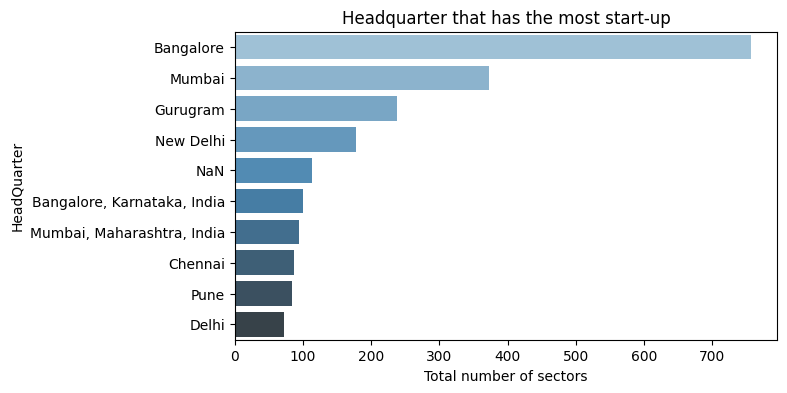

In [ ]:
plt.figure(figsize=(7, 4))
plt.title('Headquarter that has the most start-up')
plt.style.use('fivethirtyeight')
sns.barplot(y='HeadQuarter', x='Sector', palette="Blues_d", data=most_pop_location.iloc[:10])

plt.ylabel('HeadQuarter')
plt.xlabel('Total number of sectors')
plt.show()

# Question2

<b> Top 10 headquarter that has the highest start up funding<b>

In [ ]:
top_10_startup_amount = india_startup_df.groupby('HeadQuarter')['Updated_Amount'].sum().reset_index()
top_10_startup_amount = top_10_startup_amount.sort_values(by='Updated_Amount', ascending=False)
top_10_startup_amount.head(10)

,HeadQuarter,Updated_Amount
97,Mumbai,7.725692e+10
11,Bangalore,1.579046e+10
54,Gurugram,4.786832e+09
26,California,3.078300e+09
13,"Bangalore, Karnataka, India",2.291328e+09
102,New Delhi,2.265767e+09
100,NaN,2.002603e+09
98,"Mumbai, Maharashtra, India",1.788940e+09
120,Pune,1.266894e+09
52,Gurgaon,7.711630e+08


<function matplotlib.pyplot.show(close=None, block=None)>

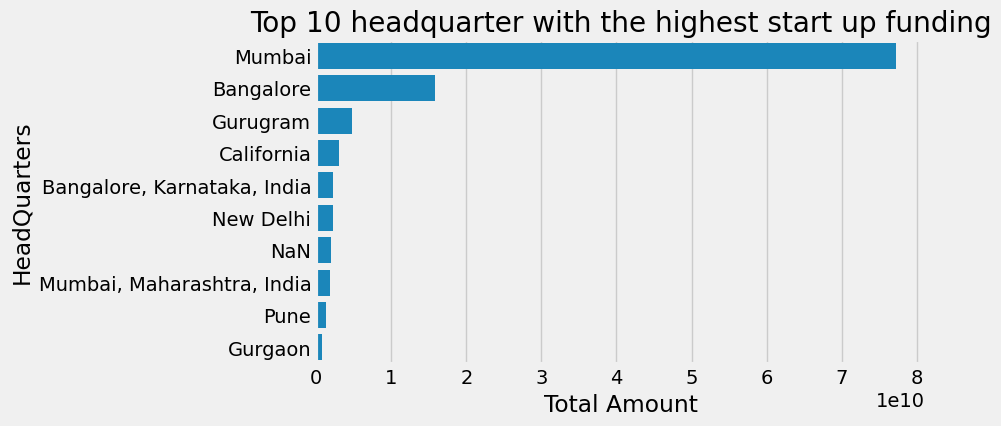

In [ ]:
plt.figure(figsize=(7,4))
plt.title('Top 10 headquarter with the highest start up funding')
plt.style.use('fivethirtyeight')
sns.barplot(x='Updated_Amount',y='HeadQuarter', palette=None, data=top_10_startup_amount.iloc[:10])

plt.ylabel('HeadQuarters')
plt.xlabel('Total Amount')

plt.show

# Question 3

<b>top 10 sector that recieve the highest start up funding<b>


In [ ]:
top_10_sector_amount = india_startup_df.groupby('Sector')['Updated_Amount'].sum().reset_index()
top_10_sector_amount = top_10_sector_amount.sort_values(by='Updated_Amount', ascending=False)
top_10_sector_amount.head(10)

,Sector,Updated_Amount
756,Retail,7.047448e+10
815,Tech company,3.022700e+09
698,Multinational conglomerate company,2.200000e+09
384,EdTech,2.124330e+09
444,FinTech,2.034610e+09
373,E-commerce,1.983532e+09
393,Edtech,1.951625e+09
100,Automotive,1.950621e+09
460,Financial Services,1.786538e+09
572,Hospitality,1.385090e+09


<function matplotlib.pyplot.show(close=None, block=None)>

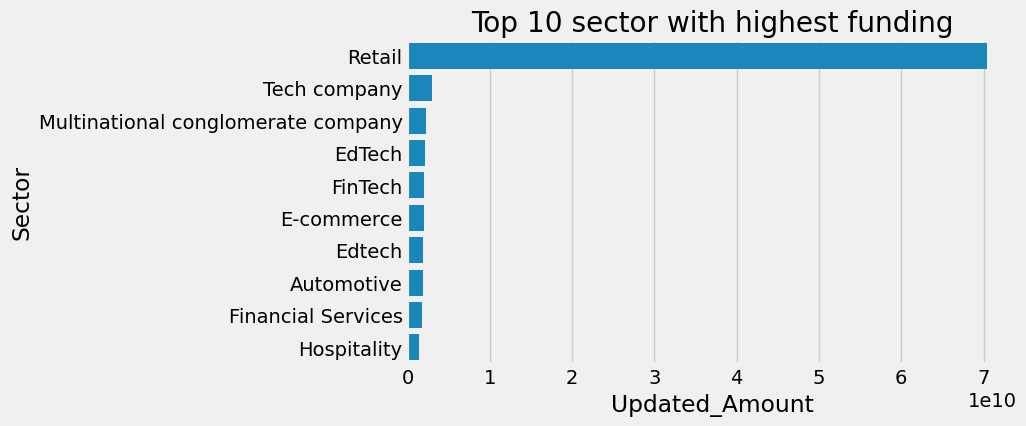

In [ ]:
plt.figure(figsize=(7,4))
plt.title('Top 10 sector with highest funding')
plt.style.use('fivethirtyeight')

sns.barplot(y='Sector', x='Updated_Amount', palette=None, data=top_10_sector_amount.iloc[:10])

plt.ylabel('Sector')
plt.xlabel('Updated_Amount')  

plt.show

# Question 4

<b>Which year recieved has the most start up funding<b>

In [ ]:
india_startup_df['Year'].unique()

array(['2018', '2019', '2020', '2021'], dtype=object)

In [ ]:
year_startup_funding=india_startup_df.groupby('Year')['Updated_Amount'].sum().reset_index()
year_startup_funding=year_startup_funding.sort_values(by='Updated_Amount', ascending=False)
year_startup_funding

,Year,Updated_Amount
2,2020,8.984482e+10
3,2021,1.965903e+10
0,2018,6.419777e+09
1,2019,3.336433e+09


<function matplotlib.pyplot.show(close=None, block=None)>

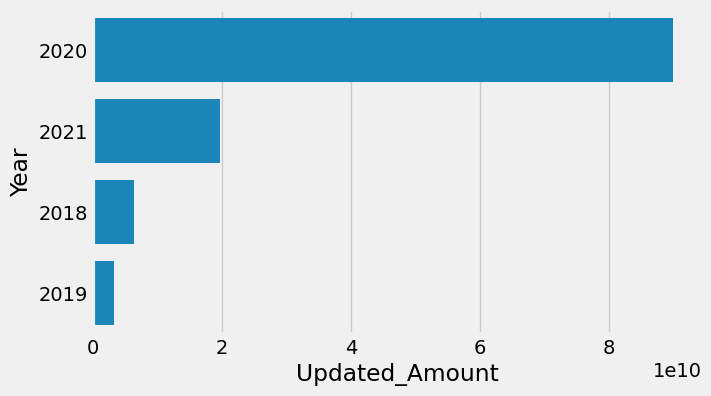

In [ ]:
plt.figure(figsize=(7,4))

sns.barplot(y='Year',x='Updated_Amount',palette=None, data=year_startup_funding)

plt.show

# Question 5

<b>What is the funding trend in the Indian start-up ecosystem over the past few years<b>

In [ ]:
# Get the Sum

total_funding = india_startup_df.groupby('Year')['Updated_Amount'].mean()

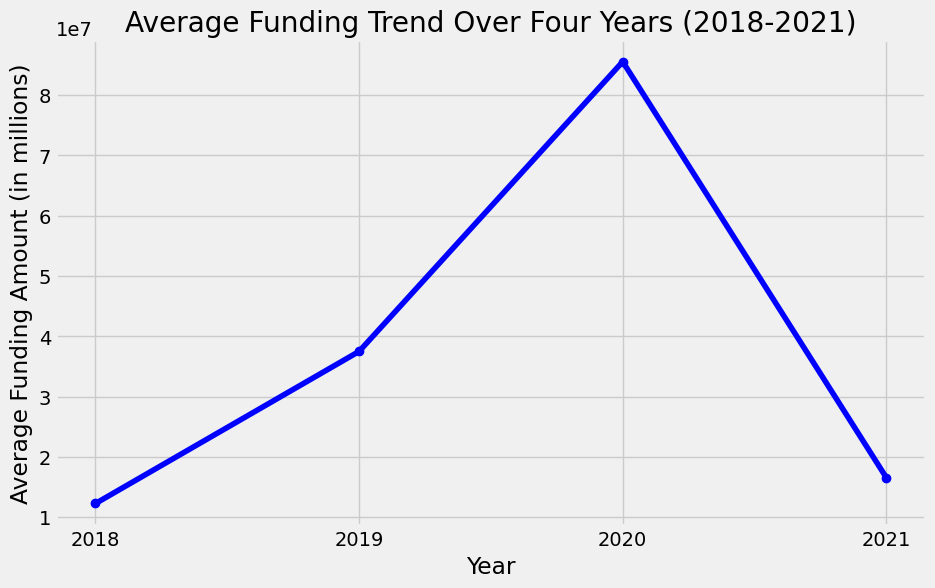

In [ ]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(total_funding.index, total_funding.values, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Average Funding Amount (in millions)')
plt.title('Average Funding Trend Over Four Years (2018-2021)')
plt.grid(True)
plt.show()